In [1]:


import pandas as pd
from helm.benchmark.runner import InstanceGenerations,GenerationSummary
from typing import Any, List
import json
from helm.common.request import (GeneratedOutput, Token)

import PostMetric
import pandas as pd

from helm.benchmark.metrics.statistic import Stat
from typing import Dict, Optional

from helm.benchmark.augmentations.perturbation_description import (
    PerturbationDescription)
from dataclasses import dataclass
from process_gens import *
from process_gen_utils import *



processGens=ProcessGens()


process_gen_modes=["fairseq_softmax", "fairseq_sparsemax"]



do_norm_analysis=True
processGens.init_with_mode(process_gen_modes)
root_folder, num_beams_list, models, custom_metrics, task_names, suite_name, instance_metrics, compare_metric = processGens.get_params()

examples_df, completions_df=get_dfs(processGens)


dfs_by_model={}

for model_name in examples_df['model'].unique():
    filtered_df = examples_df[examples_df["model"]==model_name]
    dfs_by_model[model_name]=filtered_df


/opt/miniconda3/envs/crfm-helm2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PyTorch version 2.6.0 available.


Init: process_gens_mode ['fairseq_softmax', 'fairseq_sparsemax']
calculate_gen_summary_dict
snellius_copies/helm_output/fairseq/wmt_14_language_pair_de_en_/fairseq_softmax/1_beams/runs/fairseq
get_metrics_dict
calculate_gen_summary_dict
snellius_copies/helm_output/fairseq/wmt_14_language_pair_de_en_/fairseq_sparsemax/1_beams/runs/fairseq
get_metrics_dict
Index(['example_comet', 'beam_num', 'task_name', 'model', 'example_idx',
       'rank', 'suite', 'instanceID', 'text', 'completion_length',
       'output_logprob', 'isCompletion'],
      dtype='object')
Num examples: 40000
Num completions: 400


In [2]:
print(f"\t root_folder: {root_folder} \n \t num_beams_list {num_beams_list} \n \t models: {models} \n \t custom_metrics{[metric.name() for metric in custom_metrics]}"+ 
    f"\n \t task_names {task_names} \n \t suite_name {suite_name} \n \t instance_metrics {instance_metrics}")
# instanceGeneration=get_first(processGens.first_run_instances)
print(examples_df.head(2))
print("num examples" ,len(examples_df))
print("num_completions", len(completions_df))
print(f"compare_metric mean: ",examples_df[[compare_metric]].mean())
#current belief: for each run_folder combo, there will be 100 instances and 100 examples per instance

df=next(iter(dfs_by_model.values()))
df["rank"]=100-df["example_idx"]



	 root_folder: snellius_copies/helm_output 
 	 num_beams_list [1] 
 	 models: ['fairseq_sparsemax'] 
 	 custom_metrics[]
 	 task_names ['wmt_14_language_pair_de_en_'] 
 	 suite_name fairseq 
 	 instance_metrics ['comet']
   example_comet  beam_num                    task_name            model  \
0        0.98165         1  wmt_14_language_pair_de_en_  fairseq_softmax   
1        0.98165         1  wmt_14_language_pair_de_en_  fairseq_softmax   

   example_idx  rank    suite  instanceID             text  completion_length  \
0            0   100  fairseq           0  you need time .                 15   
1            1    99  fairseq           0  you need time .                 15   

        output_logprob isCompletion  
0  -0.3601841926574707         True  
1  -0.3601841926574707         None  
num examples 40000
num_completions 400
compare_metric mean:  example_comet    0.844377
dtype: float64


/var/folders/w4/6m47nb7x1cv2hsxbb89dmcz80000gn/T/ipykernel_25905/1928941689.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rank"]=100-df["example_idx"]


In [6]:

def get_model_details(model_name):


    info_dict={
        #olmo
        "allenai_OLMo_2_0425_1B_Instruct":{"size": 1, "suite":  "olmo","model_type":"instruct", "name":"Olmo 1B Instruct"},
        "allenai_OLMo_2_0425_1B":{"size": 1, "suite":  "olmo","model_type":"base", "name":"Olmo 1B Base"},

        "allenai_OLMo_2_1124_7B_Instruct":{"size": 7, "suite":  "olmo","model_type":"instruct", "name":"Olmo 7B Instruct" },
        "allenai_OLMo_2_1124_7B":{"size": 7, "suite":  "olmo","model_type":"base", "name":"Olmo 7B Base" },

        "allenai_OLMo_2_1124_13B_Instruct":{"size": 13, "suite":  "olmo","model_type":"instruct", "name":"Olmo 13B Instruct" },
        "allenai_OLMo_2_1124_13B":{"size": 13, "suite":  "olmo","model_type":"base", "name":"Olmo 13B Base" },

        #llama instruct
        "meta_llama_Llama_3.2_1B_Instruct":{"size": 1, "suite": "llama","model_type":"instruct",  "name":"Llama 1B Instruct"},
        "meta_llama_Llama_3.2_1B":{"size": 1, "suite": "llama","model_type":"base",  "name":"Llama 1B Base"},

        "meta_llama_Llama_3.1_8B_Instruct":{"size": 8, "suite": "llama","model_type":"instruct",  "name":"Llama 8B Instruct"},
        "meta_llama_Llama_3.1_8B":{"size": 8, "suite": "llama","model_type":"base",  "name":"Llama 8B Base"},

        
        "meta-llama/Meta-Llama-3-70B-Instruct":{"size": 70, "suite": "llama","model_type":"instruct",  "name":"Llama 70B Instruct"},
        "allenai/OLMo-2-0325-32B-Instruct":{"size": 32, "suite": "olmo","model_type":"base",  "name":"Olmo 32 Base"},
        
        # #compare types
        "allenai_OLMo_2_1124_7B_DPO":{"size": 7, "suite":  "olmo","model_type":"dpo", "name":"Olmo 7B DPO" },
        "allenai_OLMo_2_1124_7B_SFT":{"size": 7, "suite":  "olmo","model_type":"sft", "name":"Olmo 7B SFT" },

        "allenai_OLMo_2_1124_13B_DPO":{"size": 13, "suite":  "olmo","model_type":"dpo", "name":"Olmo 13B DPO" },
        "allenai_OLMo_2_1124_13B_SFT":{"size": 13, "suite":  "olmo","model_type":"sft", "name":"Olmo 13B SFT" },

        "allenai_OLMo_2_1124_13B_DPO":{"size": 13, "suite":  "olmo","model_type":"dpo", "name":"Olmo 13B DPO" },
        "allenai_OLMo_2_1124_13B_SFT":{"size": 13, "suite":  "olmo","model_type":"sft", "name":"Olmo 13B SFT" },

        "Qwen_Qwen3_0.6B":{"size": 0.6, "suite":  "qwen","model_type":"base", "name":"Qwen 0.6B" },
        "Qwen_Qwen3_1.7B":{"size": 1.7, "suite":  "qwen","model_type":"base", "name":"Qwen 1.7B" },
        "Qwen_Qwen3_4B":{"size": 4, "suite":  "qwen","model_type":"base", "name":"Qwen 4B" },
        "Qwen_Qwen3_8B":{"size": 8, "suite":  "qwen","model_type":"base", "name":"Qwen 8B" },
        "Qwen_Qwen3_32B":{"size": 32, "suite":  "qwen","model_type":"base", "name":"Qwen 32B" },

        "meta_llama_Llama_3.1_8B_Instruct_template":{"size": 8, "suite": "llama","model_type":"instruct",  "name":"Llama 8B Instruct Template"},
        "allenai_OLMo_2_1124_13B_Instruct_template":{"size": 13, "suite":  "olmo","model_type":"instruct", "name":"Olmo 13B Instruct Template" },


        "fairseq_sparsemax":{"name":"Sparsemax" },
        "fairseq_softmax":{"name":"Softmax" },
        
    }
    
    for new_name, dict_name in [ ("Qwen/Qwen3-0.6B","Qwen_Qwen3_0.6B"),
        ("Qwen/Qwen3-1.7B","Qwen_Qwen3_1.7B"),
        ("Qwen/Qwen3-4B","Qwen_Qwen3_4B"),
        ("Qwen/Qwen3-8B","Qwen_Qwen3_8B"),
        ("Qwen/Qwen3-32B","Qwen_Qwen3_32B")]:
        info_dict[new_name] = info_dict[dict_name] 

    
    return info_dict[model_name]


dict_keys(['fairseq_softmax', 'fairseq_sparsemax'])
figsize is (20, 10)
model_name is fairseq_sparsemax
model_name is fairseq_softmax


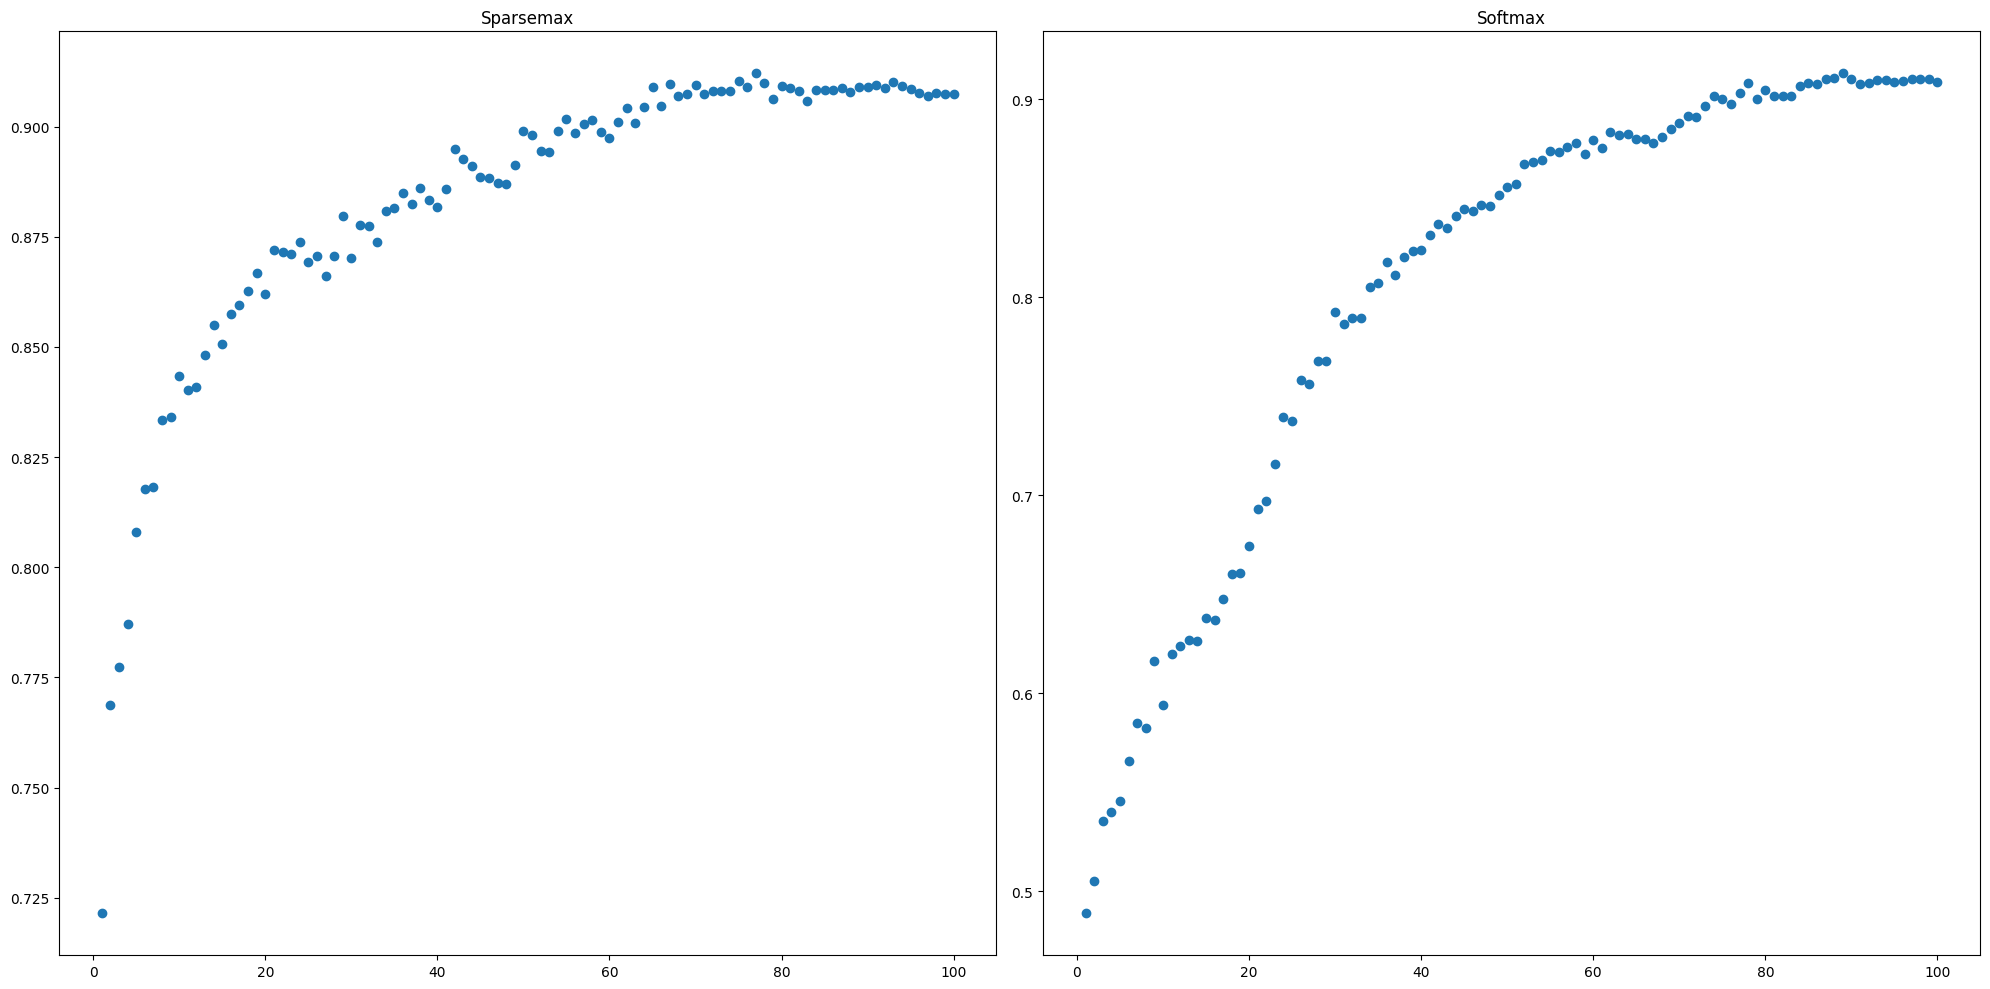

In [11]:
def special_qualitative_plots(compare_metric, models_vector, dfs_by_model, figsize=None):
    


    ncols=len(models_vector)

    if figsize is None:
        figsize=(20, 10)
        print(f"figsize is {figsize}")
    _, axes=plt.subplots(nrows=1, ncols= ncols, figsize=figsize)
    
    for col in range(ncols):
        ax=axes[col]
        if col < len(models_vector):
            model_name=models_vector[col]
            print(f"model_name is {model_name}")

            filtered_df=dfs_by_model[model_name]
            def calculate_title():
                readable_model=get_model_details(model_name)['name']
                return f"{readable_model}: {suptitle}" if ax is None else readable_model
            # plot by rank within sentence
            suptitle="Grouped by rank within sentence"
            ax=plot_grouped(df=filtered_df, xlabel="rank",groupby='example_idx', ylabel=compare_metric, title=calculate_title(), ax=ax, error_bar=False)  
            ax.set_xlabel(None)
            ax.set_ylabel(None)
        else:
            ax.axis('off')

        
    plt.tight_layout()

print(dfs_by_model.keys())
compare_metrics=[compare_metric, compare_metric]
models_vector=["fairseq_sparsemax", "fairseq_softmax"]
special_qualitative_plots(compare_metric=compare_metric, models_vector=models_vector, dfs_by_model=dfs_by_model, figsize=None)
